In [1]:
import numpy as np
import matplotlib.pyplot as plt
from load_MNIST import MnistDataloader
from os.path import join
import random
import time
import math
%matplotlib inline
np.random.seed(1)

Number of training examples in training set : 60000
Number of training examples in test set : 10000
size of each image : 28*28


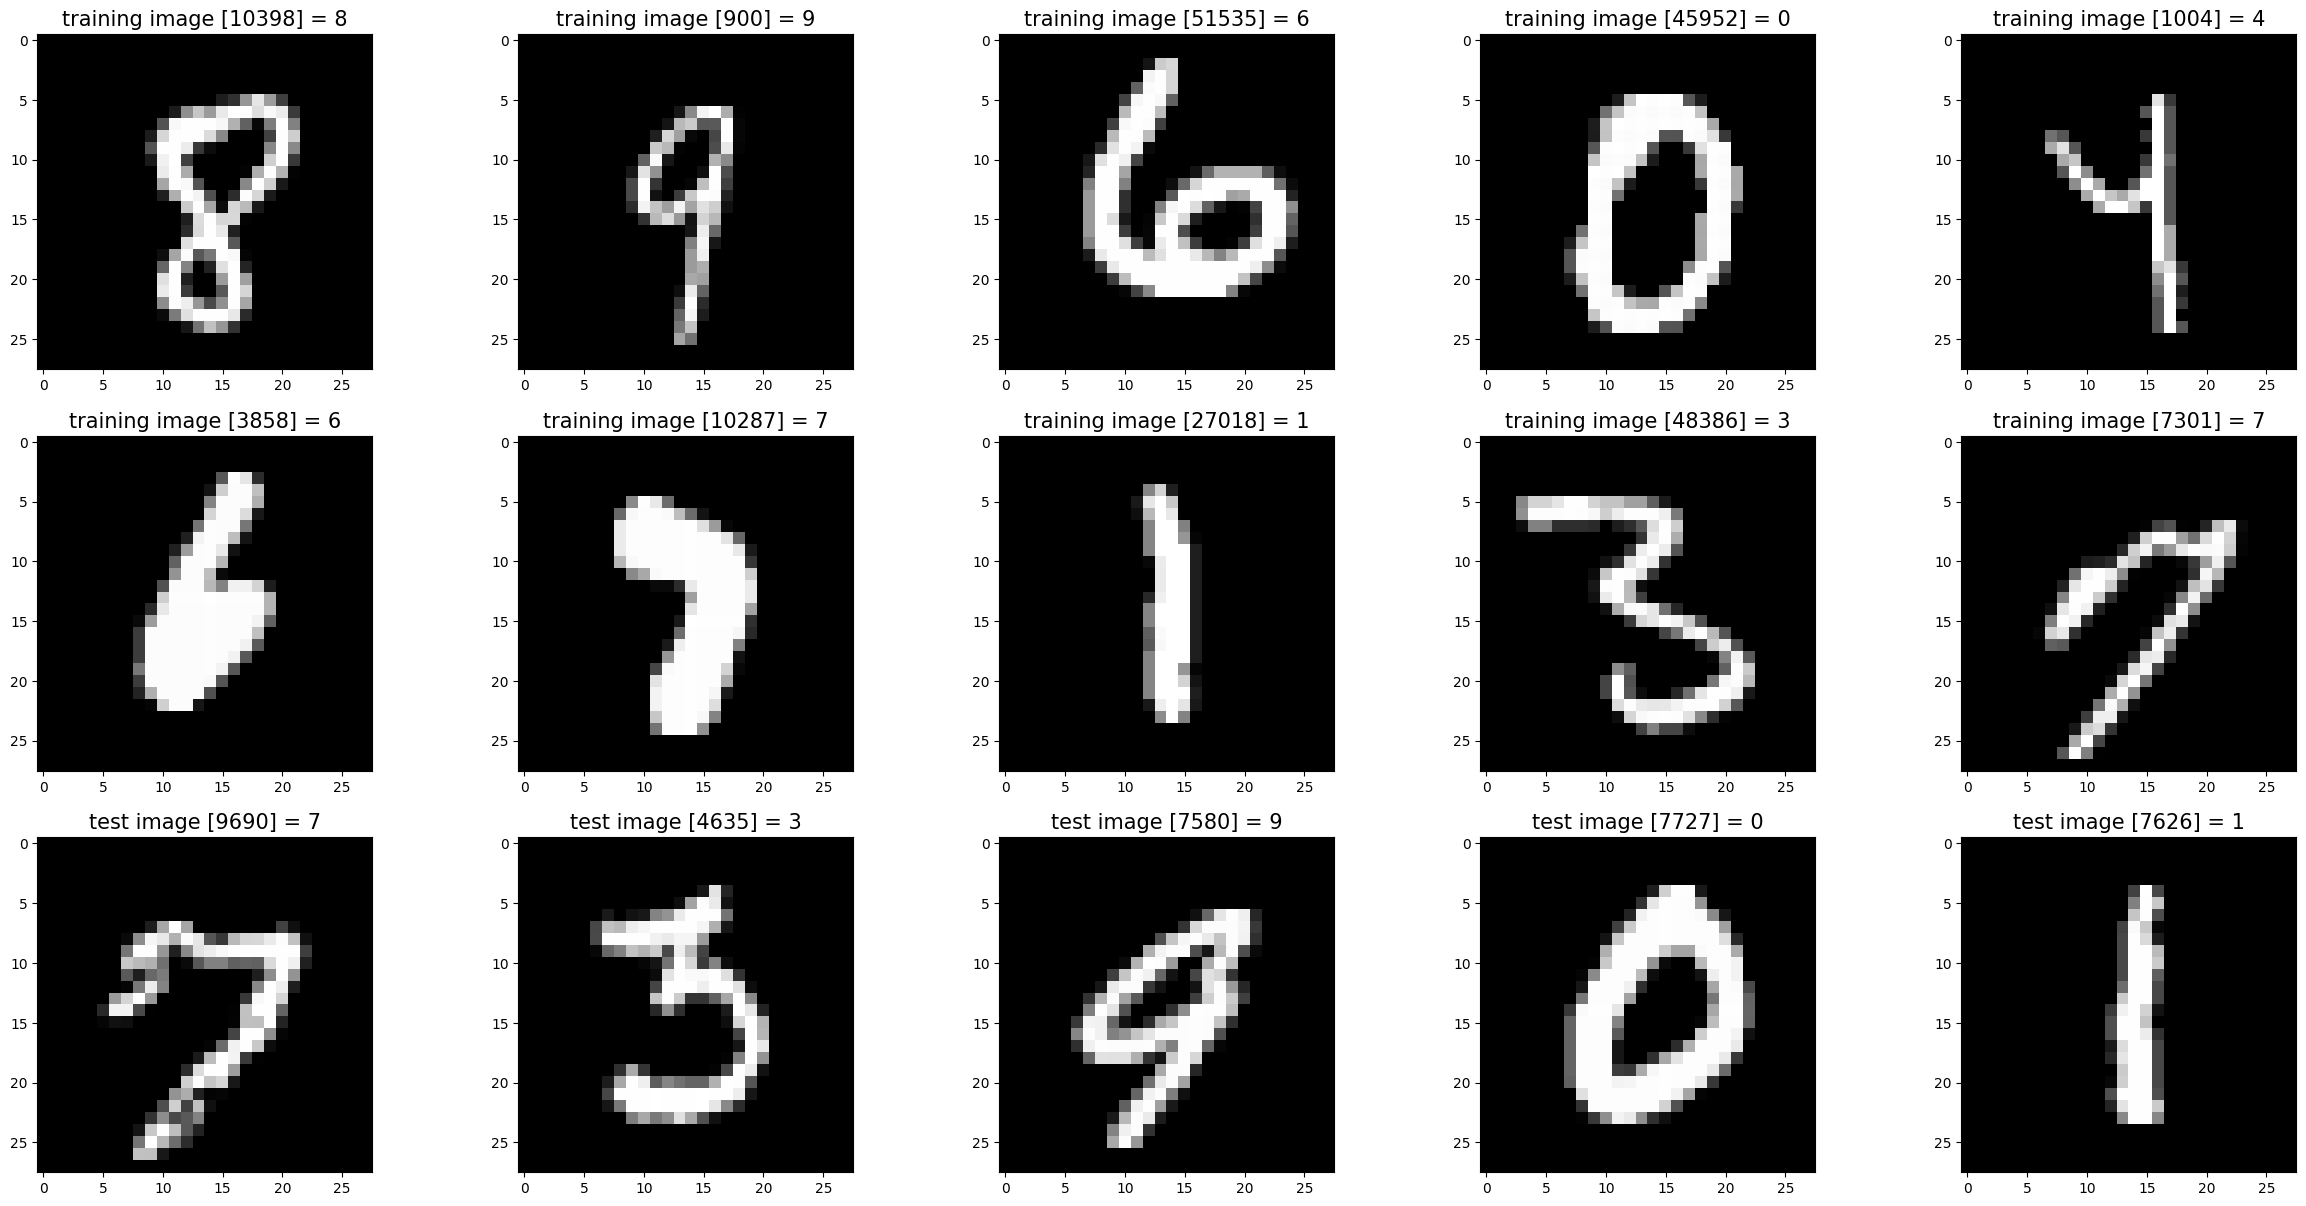

In [2]:
#Loading MNIST dataset
input_path = 'datasets/MNIST_dataset/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

m_train = len(x_train)
m_test = len(x_test)
num_pixel = len(x_train[0])

print(f"Number of training examples in training set : {m_train}")
print(f"Number of training examples in test set : {m_test}")
print(f"size of each image : {num_pixel}*{num_pixel}")

In [3]:
#unrolling the training and testing data
x_train = np.array(x_train).reshape((60000, 28*28)).T / 255.0
x_test = np.array(x_test).reshape((10000, 28*28)).T / 255.0    

y_train = np.array(y_train).reshape((1, 60000))  
y_test = np.array(y_test).reshape((1, 10000))   

In [4]:
def dictionary_to_vector(parameters):
    keys = []
    count = 0
    for key in ["W1", "b1", "gamma1","beta1", "W2", "b2", "gamma2","beta2", "W3", "b3"]:
        
        # flatten parameter
        new_vector = np.reshape(parameters[key], (-1,1))
        keys = keys + [key]*new_vector.shape[0]
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta, keys

def vector_to_dictionary(theta):
    parameters = {}
    parameters["W1"]     = theta[0:19600].reshape((25,784))
    parameters["b1"]     = theta[19600:19625].reshape((25,1))
    parameters["gamma1"] = theta[19625:19650].reshape((25,1))
    parameters["beta1"]  = theta[19650:19675].reshape((25,1))
    parameters["W2"]     = theta[19675:20050].reshape((15,25))
    parameters["b2"]     = theta[20050:20065].reshape((15,1))
    parameters["gamma2"] = theta[20065:20080].reshape((15,1))
    parameters["beta2"]  = theta[20080:20095].reshape((15,1))
    parameters["W3"]     = theta[20095:20245].reshape((10,15))
    parameters["b3"]     = theta[20245:20255].reshape((10,1))

    return parameters

def gradients_to_vector(gradients):
    count = 0
    for key in ["dW1", "db1","dgamma1", "dbeta1", "dW2", "db2", "dgamma2", "dbeta2", "dW3", "db3"]:
        # flatten parameter
        new_vector = np.reshape(gradients[key], (-1,1))
        
        if count == 0:
            theta = new_vector
        else:
            theta = np.concatenate((theta, new_vector), axis=0)
        count = count + 1

    return theta

In [5]:
def relu(Z):
    return np.maximum(Z,0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def d_relu(Z):
    return Z>0

def one_hot_encoding(Y):
    one_hot_Y = np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [6]:
def initialize_parameters(layer_dims):
    L = len(layer_dims)

    parameters = {}
    for l in range(1,L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l],1))
        if l < L-1:
            parameters[f"gamma{l}"] = np.ones((layer_dims[l],1))
            parameters[f"beta{l}"] = np.zeros((layer_dims[l],1))
            parameters[f"running_mean{l}"] = np.zeros((layer_dims[l],1))
            parameters[f"running_var{l}"] = np.ones((layer_dims[l],1))

    return parameters

In [7]:
def forward_propogation_layer(A_prev, W, b, activation, keep_prob=1, epsilon=1e-8,gamma=None, beta=None, running_mean=None, running_var=None, momentum=0.9, training=True):
    m = A_prev.shape[1]
    
    Z = np.dot(W,A_prev) + b
    mu, var = None,None
    Z_norm = None
    if gamma is not None and beta is not None:
        if training:
            mu = np.mean(Z, axis = 1, keepdims = True)
            var = np.var(Z, axis = 1, keepdims = True)
            Z_norm = (Z-mu)/(np.sqrt(var + epsilon))
        
            running_mean = momentum * running_mean + (1 - momentum) * mu
            running_var = momentum * running_var + (1 - momentum) * var
        else:
             Z_norm = (Z - running_mean) / np.sqrt(running_var + epsilon)
            

        BN_out = gamma*Z_norm + beta
    else:
        BN_out = Z
    
    if activation == "relu":
        A = relu(BN_out)
    elif activation == "softmax":
        A = softmax(BN_out)

    if keep_prob < 1 and training:
        D = np.random.rand(A.shape[0],A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A*D
        A = A/keep_prob
    else:
        D = None

    linear_cache = (W,b,A_prev)
    activation_cache = (BN_out,)
    dropout_cache = (D,)
    bn_cache = (Z, Z_norm, mu, var, gamma, beta)
    
    return A,(linear_cache, activation_cache, dropout_cache, bn_cache), running_mean, running_var

In [8]:
def forward_propogation(X, parameters, keep_prob, epsilon, momentum=0.9, training=True):
    L = len([k for k in parameters.keys() if k.startswith("W")])
    caches = []
    A = X
    
    for l in range(1,L):
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        gamma = parameters[f"gamma{l}"]
        beta = parameters[f"beta{l}"]
        running_mean = parameters[f"running_mean{l}"]
        running_var = parameters[f"running_var{l}"]
        A,cache,rm,rv = forward_propogation_layer(A, W, b, "relu", keep_prob, epsilon, gamma=gamma, beta=beta, running_mean=running_mean, running_var=running_var, momentum=momentum, training=training)
        parameters[f"running_mean{l}"] = rm
        parameters[f"running_var{l}"] = rv
        caches.append(cache)

    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    AL,cache,_,_ = forward_propogation_layer(A, W, b, "softmax", keep_prob = 1, epsilon=epsilon, training = training)
    caches.append(cache)
    
    return AL,caches

In [9]:
def compute_cost(Y,AL,parameters,lambd):
    Y = one_hot_encoding(Y)
    m = Y.shape[1]
    L = L = sum(1 for k in parameters.keys() if k.startswith("W"))
    regularization_cost = 0
    
    for l in range(1,L+1):
        regularization_cost += (lambd/(2*m))*np.sum(np.square(parameters[f"W{l}"]))
        
    cost = (-np.sum(Y * np.log(AL + 1e-8)) / m) + (regularization_cost)  
    return float(np.squeeze(cost))

In [10]:
def backpropogation_layer(dA, c_cache, activation, lambd, keep_prob, is_last_layer=False, epsilon=1e-8):
    linear_cache = c_cache[0]
    activation_cache = c_cache[1]
    dropout_cache = c_cache[2]
    bn_cache = c_cache[3]

    grad = {}
    
    W = linear_cache[0]
    b = linear_cache[1]
    A_prev = linear_cache[2]
    
    BN_out = activation_cache[0]

    D = dropout_cache[0]

    Z, Z_norm, mu, var, gamma, beta = bn_cache
    m = Z.shape[1]

    if not is_last_layer and D is not None:
        dA = dA*D
        dA = dA/keep_prob
    
    if activation == "relu":
        dBN_out = dA*d_relu(BN_out)
        dgamma = np.sum(dBN_out * Z_norm, axis=1, keepdims=True)
        dbeta = np.sum(dBN_out, axis=1, keepdims=True)
        dZ_norm = dBN_out * gamma
    
        dvar = np.sum(dZ_norm * (Z - mu) * (-0.5) * (var + epsilon) ** (-1.5), axis=1, keepdims=True)
        dmu = (np.sum(dZ_norm * (-1 / np.sqrt(var + epsilon)), axis=1, keepdims=True) + dvar * np.sum(-2 * (Z - mu), axis=1, keepdims=True) / m)
    
        dZ = dZ_norm / np.sqrt(var + epsilon) + (dvar * 2 * (Z - mu) / m) + (dmu / m)

        grad["dgamma"] = dgamma
        grad["dbeta"] = dbeta
        
    elif activation == "softmax":
        dZ = dA
    
    dW = np.dot(dZ,A_prev.T)/m + (lambd/m)*W
    db = np.sum(dZ, axis=1, keepdims = True)/m
    dA = np.dot(W.T,dZ)    

    grad["dW"] = dW
    grad["db"] = db

    return dA,grad

In [11]:
def backpropogation(AL, caches,Y,lambd,keep_prob):
    L = len(caches)
    grads = {}
    one_hot_Y = one_hot_encoding(Y)
    dA = AL - one_hot_Y
    c_cache = caches[L-1]
    dA, grad = backpropogation_layer(dA, c_cache, "softmax", lambd, keep_prob, is_last_layer=True)

    grads[f"dW{L}"] = grad["dW"]
    grads[f"db{L}"] = grad["db"]
    
    for l in range(L-2,-1,-1):
        c_cache = caches[l]
        dA, grad = backpropogation_layer(dA, c_cache, "relu", lambd, keep_prob)

        grads[f"dW{l + 1}"] = grad["dW"]
        grads[f"db{l + 1}"] = grad["db"]
        grads[f"dgamma{l+1}"] = grad["dgamma"]
        grads[f"dbeta{l+1}"] = grad["dbeta"]

    return grads
        

In [12]:
def update_parameters(grads, parameters, learning_rate):
    L = sum(1 for k in parameters.keys() if k.startswith("W"))

    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

        if f"dgamma{l}" in grads:  
            parameters[f"gamma{l}"] -= learning_rate * grads[f"dgamma{l}"]
            parameters[f"beta{l}"] -= learning_rate * grads[f"dbeta{l}"]

    return parameters

In [13]:
def adam_optimizer(grads, parameters, v, s, learning_rate, beta_1, beta_2, t, epsilon=1e-8):
    L = sum(1 for k in parameters.keys() if k.startswith("W"))

    v_corrected = {}
    s_corrected = {}

    for l in range(1,L+1):
        v[f"dW{l}"] = v[f"dW{l}"]*beta_1 + (1-beta_1)*grads[f"dW{l}"]
        v[f"db{l}"] = v[f"db{l}"]*beta_1 + (1-beta_1)*grads[f"db{l}"]

        v_corrected[f"dW{l}"] = v[f"dW{l}"]/(1-beta_1**t)
        v_corrected[f"db{l}"] = v[f"db{l}"]/(1-beta_1**t)

        s[f"dW{l}"] = s[f"dW{l}"]*beta_2 + (1-beta_2)*np.square(grads[f"dW{l}"])
        s[f"db{l}"] = s[f"db{l}"]*beta_2 + (1-beta_2)*np.square(grads[f"db{l}"])

        s_corrected[f"dW{l}"] = s[f"dW{l}"]/(1-beta_2**t)
        s_corrected[f"db{l}"] = s[f"db{l}"]/(1-beta_2**t)

        if f"dgamma{l}" in grads:
            v[f"dgamma{l}"] = v[f"dgamma{l}"]*beta_1 + (1-beta_1)*grads[f"dgamma{l}"]
            v[f"dbeta{l}"] = v[f"dbeta{l}"]*beta_1 + (1-beta_1)*grads[f"dbeta{l}"]
        
            v_corrected[f"dgamma{l}"] = v[f"dgamma{l}"]/(1-beta_1**t)
            v_corrected[f"dbeta{l}"] = v[f"dbeta{l}"]/(1-beta_1**t)
        
            s[f"dgamma{l}"] = s[f"dgamma{l}"]*beta_2 + (1-beta_2)*np.square(grads[f"dgamma{l}"])
            s[f"dbeta{l}"] = s[f"dbeta{l}"]*beta_2 + (1-beta_2)*np.square(grads[f"dbeta{l}"])
        
            s_corrected[f"dgamma{l}"] = s[f"dgamma{l}"]/(1-beta_2**t)
            s_corrected[f"dbeta{l}"] = s[f"dbeta{l}"]/(1-beta_2**t)
        
            parameters[f"gamma{l}"] -= learning_rate * (v_corrected[f"dgamma{l}"]/(np.sqrt(s_corrected[f"dgamma{l}"]) + epsilon))
            parameters[f"beta{l}"] -= learning_rate * (v_corrected[f"dbeta{l}"]/(np.sqrt(s_corrected[f"dbeta{l}"]) + epsilon))

        parameters[f"W{l}"] = parameters[f"W{l}"] - learning_rate*(v_corrected[f"dW{l}"]/(np.sqrt(s_corrected[f"dW{l}"]) + epsilon))
        parameters[f"b{l}"] = parameters[f"b{l}"] - learning_rate*(v_corrected[f"db{l}"]/(np.sqrt(s_corrected[f"db{l}"]) + epsilon))

    return parameters,v,s

In [14]:
def predict(parameters, X, Y):
    A,_ = forward_propogation(X, parameters, keep_prob=1, epsilon=1e-8, training=True)
    prediction = np.argmax(A,0)
    accuracy = np.sum(prediction==Y)/A.shape[1]
    return accuracy,prediction

In [15]:
def initialize_adam(parameters):
    L = sum(1 for k in parameters.keys() if k.startswith("W"))

    v = {}
    s = {}
    
    for l in range(1,L+1):
        v[f"dW{l}"] = np.zeros(parameters[f"W{l}"].shape)
        v[f"db{l}"] = np.zeros(parameters[f"b{l}"].shape)
        s[f"dW{l}"] = np.zeros(parameters[f"W{l}"].shape)
        s[f"db{l}"] = np.zeros(parameters[f"b{l}"].shape)

        if f"gamma{l}" in parameters:
            v[f"dgamma{l}"] = np.zeros(parameters[f"gamma{l}"].shape)
            v[f"dbeta{l}"] = np.zeros(parameters[f"beta{l}"].shape)
            s[f"dgamma{l}"] = np.zeros(parameters[f"gamma{l}"].shape)
            s[f"dbeta{l}"] = np.zeros(parameters[f"beta{l}"].shape)

    return v,s

In [16]:
def initialize_mini_batch(X, Y, mini_batch_size, seed):

    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    num_mini_batches = math.floor(m/mini_batch_size)
    for i in range(num_mini_batches):
        mini_batch_X = X_shuffled[:,mini_batch_size*i : mini_batch_size*(i+1)]
        mini_batch_Y = Y_shuffled[:,mini_batch_size*i : mini_batch_size*(i+1)]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m%mini_batch_size != 0:
        mini_batch_X = X_shuffled[:,mini_batch_size*(num_mini_batches) : ]
        mini_batch_Y = Y_shuffled[:,mini_batch_size*(num_mini_batches) : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def gradient_checking(parameters, gradients, X, Y, epsilon=np.float64(1e-7)):

    parameter_values, _ = dictionary_to_vector(parameters)
    gradient_values = gradients_to_vector(gradients)
    num_of_parameters = parameter_values.shape[0]
    grad_approx = np.zeros((num_of_parameters,1))
    J_plus = np.zeros((num_of_parameters,1))
    J_minus = np.zeros((num_of_parameters,1))

    for i in range(100): #for testing check on only 100 params
        
        theta_plus = np.copy(parameter_values)
        theta_plus[i][0] += epsilon
        AL,_ = forward_propogation(X,vector_to_dictionary(theta_plus),1)
        J_plus[i][0] = compute_cost(Y,AL,vector_to_dictionary(theta_plus),0)

        theta_minus = np.copy(parameter_values)
        theta_minus[i][0] -= epsilon
        AL,_ = forward_propogation(X,vector_to_dictionary(theta_minus),1)
        J_minus[i][0] = compute_cost(Y,AL,vector_to_dictionary(theta_minus),0)

        grad_approx[i][0] = (J_plus[i][0] - J_minus[i][0])/(2*epsilon)

    numerator = np.linalg.norm(gradient_values[0:100,0] - grad_approx[0:100,0])
    denominator = np.linalg.norm(grad_approx[0:100,0]) + np.linalg.norm(gradient_values[0:100,0])
    
    difference = numerator/denominator  
    
    if difference > 1e-7:
        print(f"Error in gradient descent, difference : {difference}")
    else:
        print(f"Gradient descent works well! difference : {difference}")

In [18]:
def model(X, Y, layer_dims, learning_rate, epochs, lambd, keep_prob, mini_batch_size, beta_1, beta_2, print_cost, grad_check):
    m = X.shape[1]
    n = X.shape[0]
    parameters = initialize_parameters(layer_dims)
    v,s = initialize_adam(parameters)
    t = 0
    J_cache = []
    seed = 10
    for e in range(epochs): 
        seed += 1
        mini_batches = initialize_mini_batch(X, Y, mini_batch_size, seed)
        avg_cost = 0
        num_batches = len(mini_batches)
        for i in range(num_batches):
            x,y = mini_batches[i]
            AL,caches = forward_propogation(x, parameters, keep_prob, epsilon=1e-8, training=True)
            J = compute_cost(y, AL, parameters, lambd)
            grads = backpropogation(AL, caches, y, lambd, keep_prob) 
            #parameters = update_parameters(grads, parameters, learning_rate)
            t+=1
            parameters,v,s = adam_optimizer(grads, parameters, v, s, learning_rate, beta_1, beta_2, t)
    
            avg_cost += J
            
        avg_cost = avg_cost/num_batches
        J_cache.append(avg_cost)
        
        if e%100 == 0 and print_cost:
            accuracy,_ = predict(parameters,X,Y)
            print(f"Cost at epoch {e} : {avg_cost}, Accuracy of the model : {accuracy*100}%")
            if accuracy == 1: break

        if e%500 == 0 and grad_check:
            gradient_checking(parameters, grads, X, Y)

    plt.plot(J_cache)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters
            

Cost at epoch 0 : 1.9300640422267237, Accuracy of the model : 88.47333333333334%
Cost at epoch 100 : 0.14850066101784462, Accuracy of the model : 98.05333333333334%
Cost at epoch 200 : 0.1291889233712689, Accuracy of the model : 98.22333333333333%
Cost at epoch 300 : 0.12459575625102566, Accuracy of the model : 98.39%
Cost at epoch 400 : 0.12093776103827068, Accuracy of the model : 98.35166666666667%
Cost at epoch 500 : 0.11708561194395306, Accuracy of the model : 98.39166666666667%
Cost at epoch 600 : 0.11572850164258272, Accuracy of the model : 98.32666666666667%
Cost at epoch 700 : 0.11317414280968668, Accuracy of the model : 98.55000000000001%
Cost at epoch 800 : 0.11384014575680938, Accuracy of the model : 98.42666666666666%
Cost at epoch 900 : 0.11277875154328565, Accuracy of the model : 98.32833333333333%
Cost at epoch 1000 : 0.11258366900027583, Accuracy of the model : 98.56166666666667%


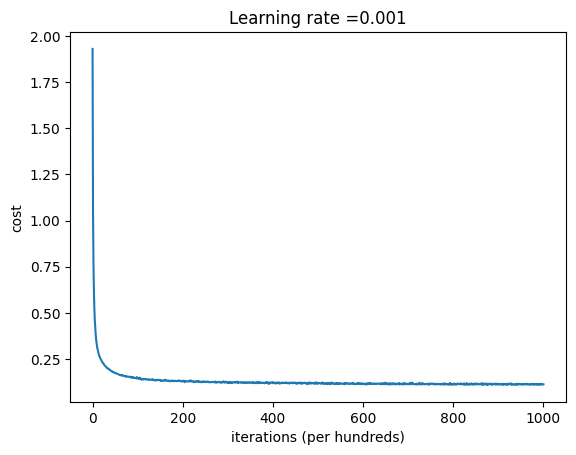

Elapsed time : 10.992103215058645 mins 59.52619290351868 secs


In [19]:
layer_dims = [num_pixel*num_pixel,25,15,10]
start = time.time()
parameters = model(x_train, y_train, layer_dims, 0.001, 1001, 10, 0.999, 512, 0.9, 0.999, True, False)
end = time.time()
print(f"Elapsed time : {(end-start)/60} mins {(end-start)%60} secs")

In [20]:
train_accuracy, train_prediction = predict(parameters, x_train, y_train)

In [21]:
print(f"Accuracy on training set : {train_accuracy*100}%")

Accuracy on training set : 98.56166666666667%


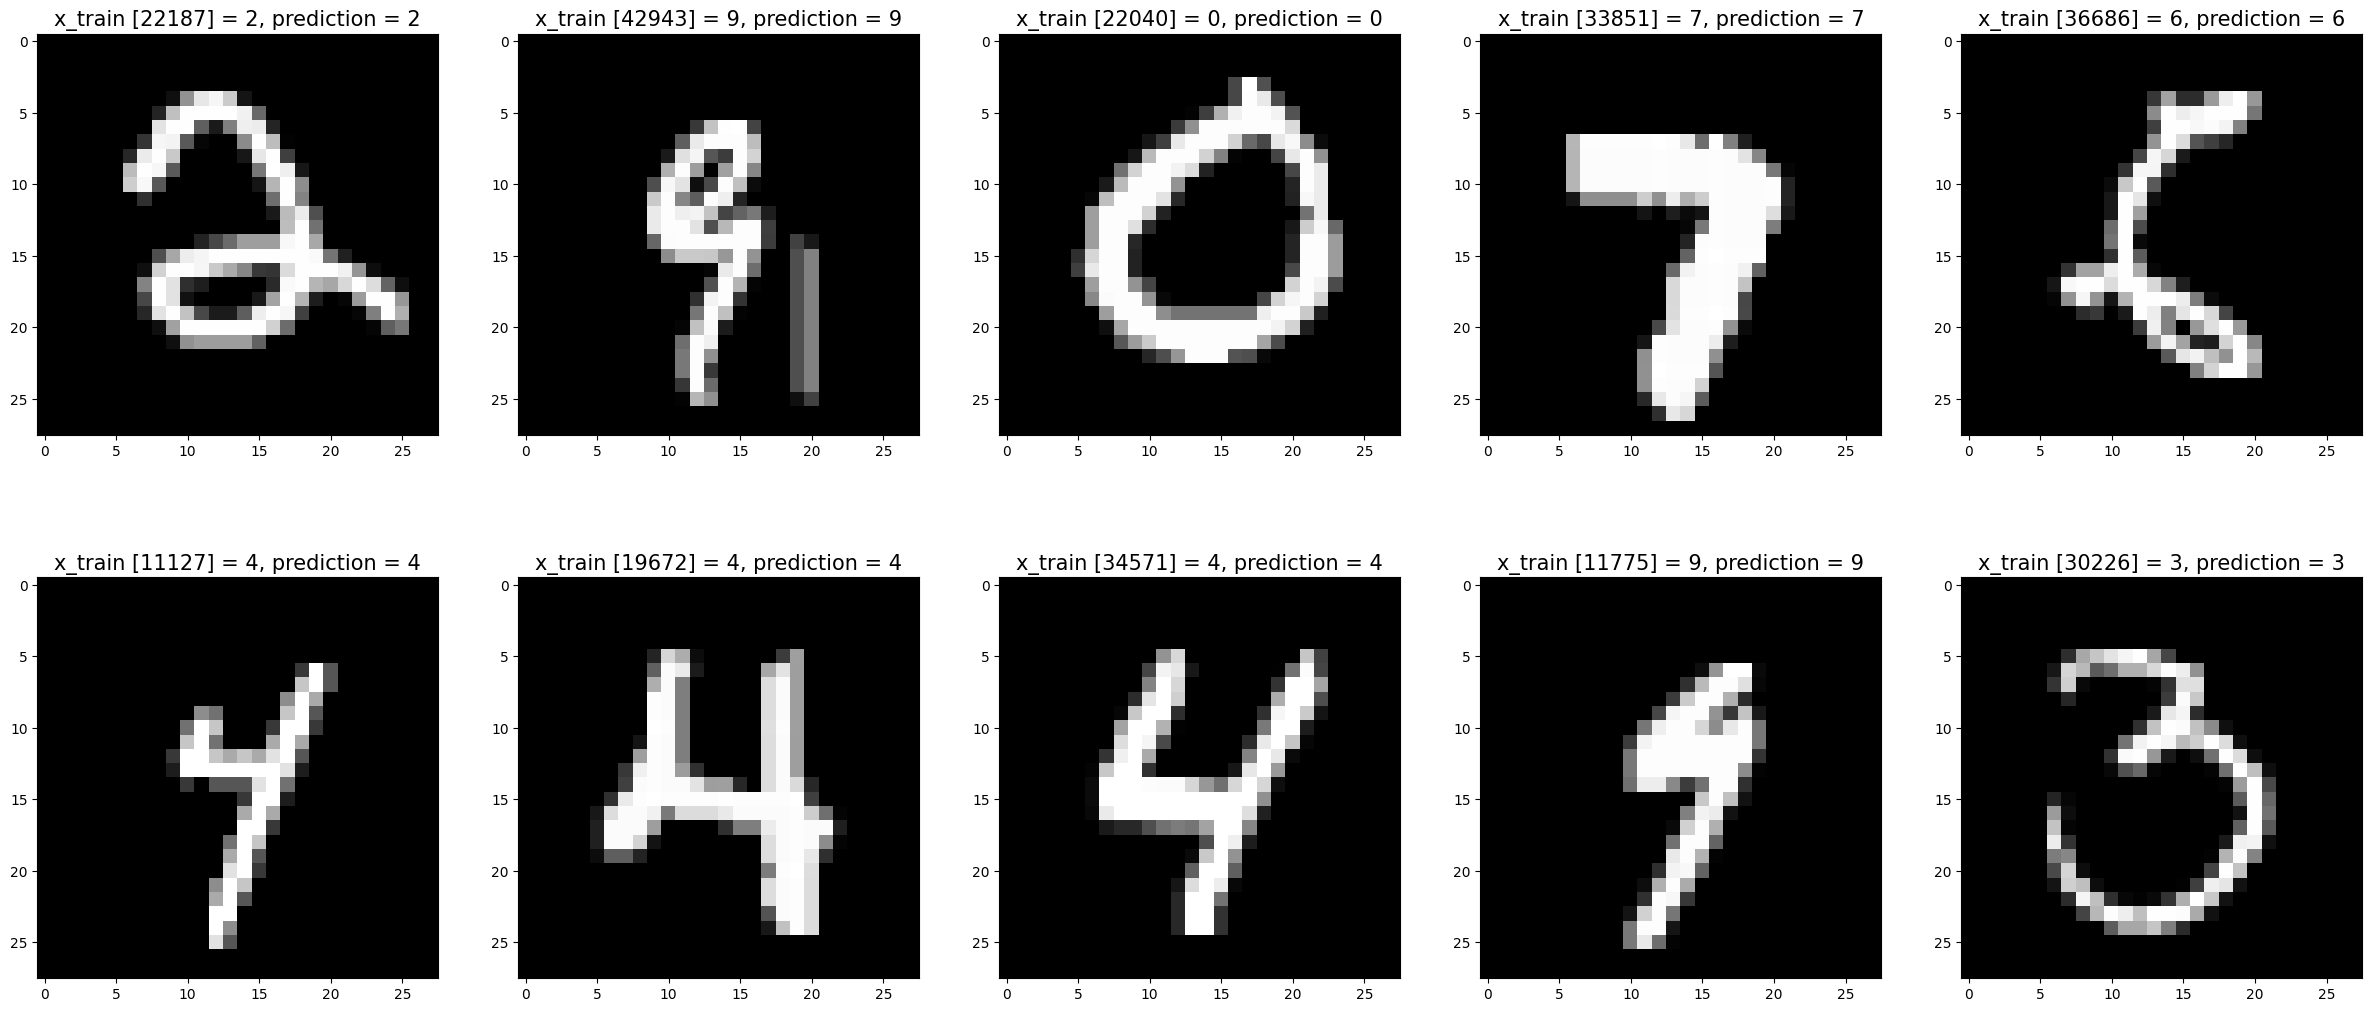

In [22]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, m_train)
    images_2_show.append(x_train[:,r].reshape((num_pixel,num_pixel)))
    titles_2_show.append('x_train [' + str(r) + '] = ' + str(y_train[0,r]) + ', prediction = ' + str(train_prediction[r]))    

show_images(images_2_show, titles_2_show)

In [23]:
test_accuracy,test_prediction = predict(parameters,x_test,y_test)

In [24]:
print(f"Accuracy on test set : {test_accuracy*100}%")

Accuracy on test set : 97.46000000000001%


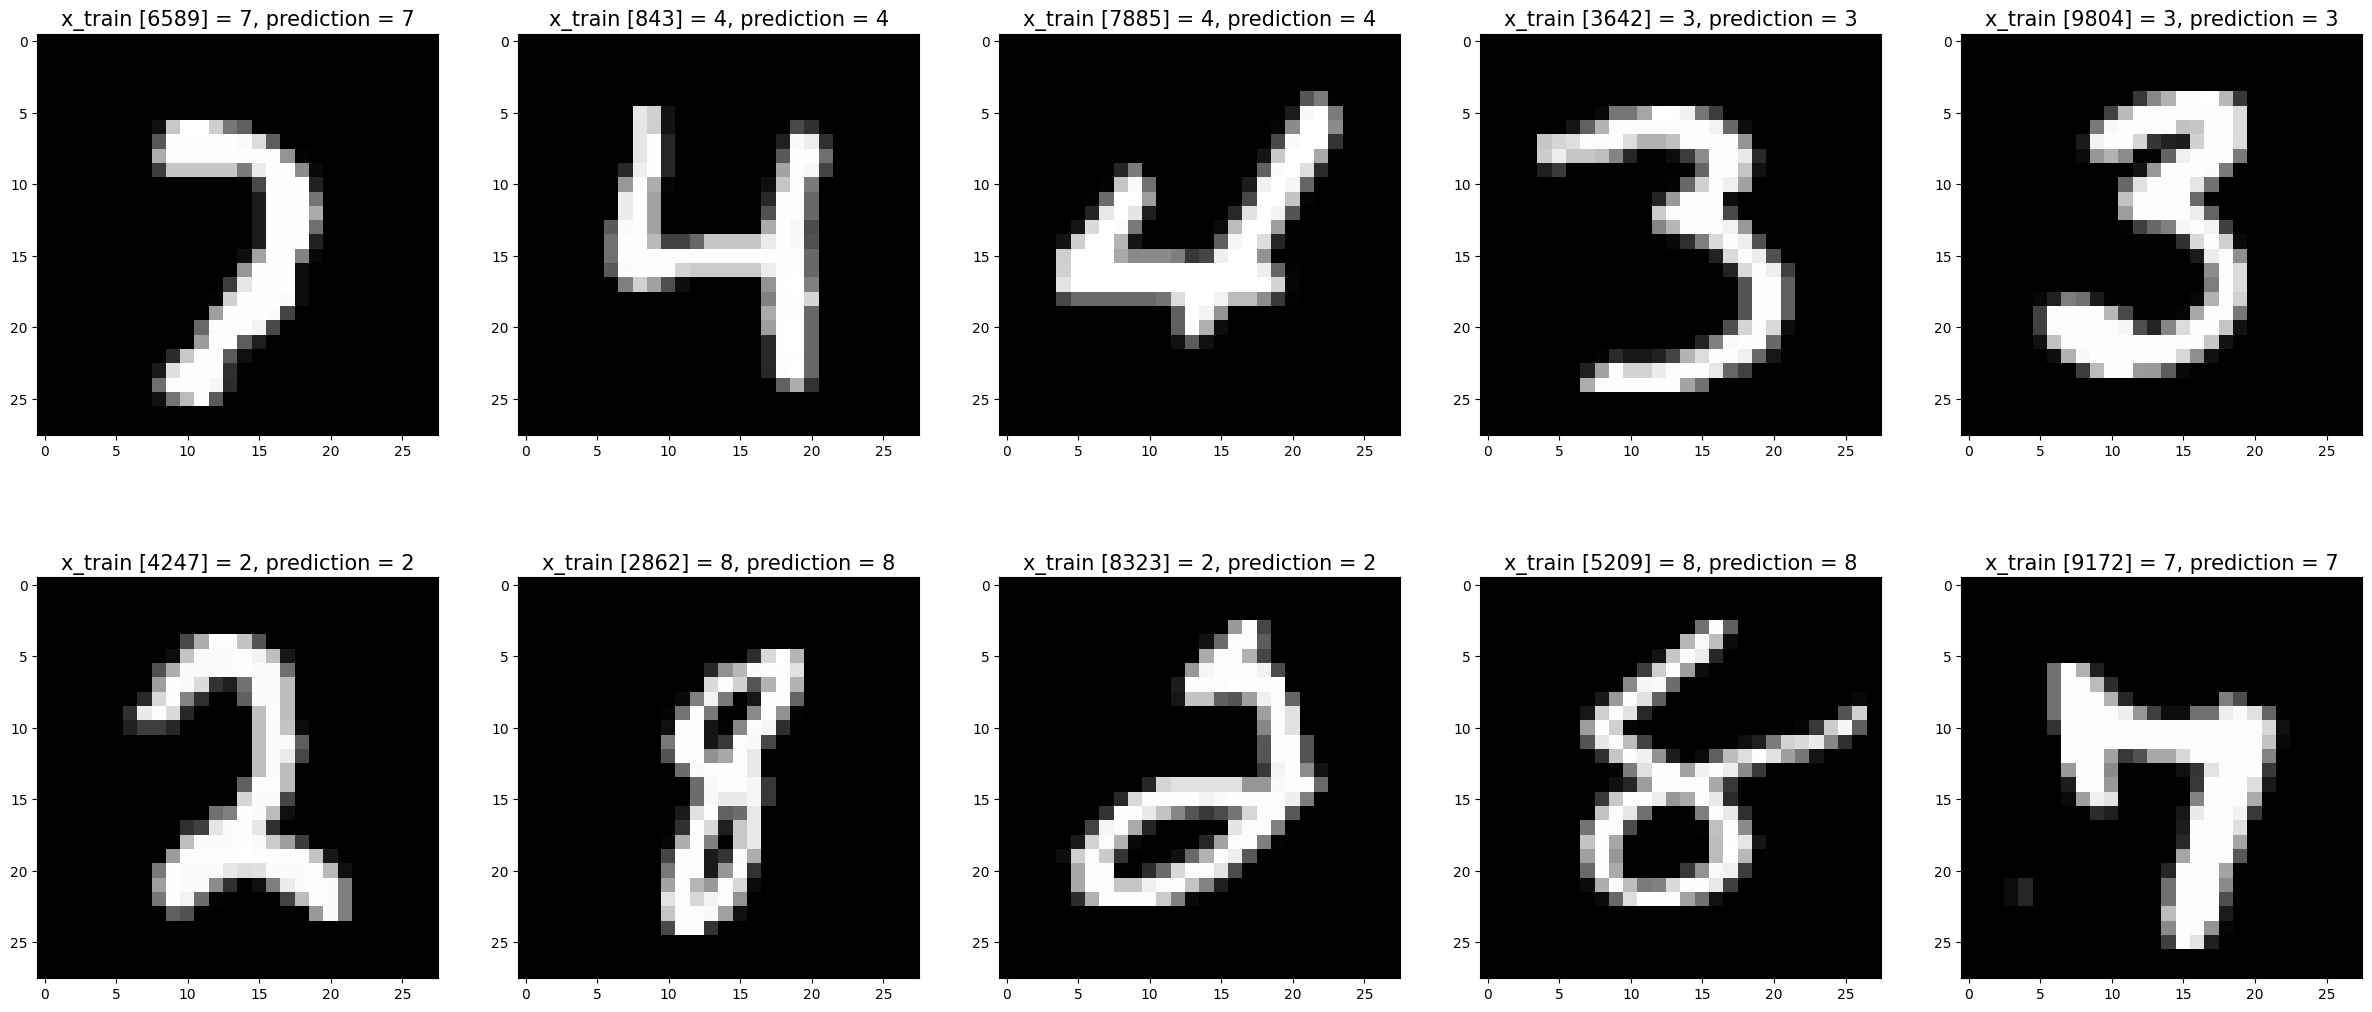

In [25]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, m_test)
    images_2_show.append(x_test[:,r].reshape((num_pixel,num_pixel)))
    titles_2_show.append('x_train [' + str(r) + '] = ' + str(y_test[0,r]) + ', prediction = ' + str(test_prediction[r]))    

show_images(images_2_show, titles_2_show)